# **Practical Time Series Forecasting with R**
## Chapter 6: Regression Based Models: Capturing Trend & Seasonality

In [1]:
## ESTABLISH ENVIRONMENT
# Built-in libraries
from datetime import datetime
from pathlib import Path

# Third-party libraries for data handling and scientific computation
import numpy as np
import pandas as pd

# Libraries for statistical and econometric models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.api import OLS, add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant ## Table 6.5
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Libraries for preprocessing and visualization
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

## AMTRAK IMPORT FORMATTING
def convert_date(date_str):
    # if the string is 'nan' (which can occur if there was a NaN entry in the original data)
    if date_str == 'nan':
        return None
    # try to parse the date assuming it's in the format 'Dec-00'
    try:
        date = datetime.strptime(date_str, '%b-%y')
        if date.year > datetime.now().year:
            date = date.replace(year=date.year-100) # replace century if needed
    except ValueError:
        # if that fails, assume it's in the format '1-Dec'
        try:
            date = datetime.strptime(date_str, '%d-%b')
            # assuming all dates are in 2000s
            date = date.replace(year=2000 + int(date_str.split('-')[0]))
        except ValueError:
            # if both formats fail, return None or handle as you see fit
            return None
    # convert the date into the desired format
    return date.strftime('%B %Y')


## AMTRAK GRAPH FORMATTING
def Amtrak_PlotGraph(train, valid, pred_dict_train, pred_dict_valid, **kwargs):
    TextHight = kwargs.get('TextHight', 2600) # Default value is 2600 if not provided
    fig, ax = plt.subplots()

    # Define color palette with distinct colors
    color_palette = plt.cm.get_cmap('tab10', 10)
    
    ax.plot(train.index, train, label='Training Data', linewidth=2, color=color_palette(0))
    ax.plot(valid.index, valid, label='Validation Data', color=color_palette(0))
    
    for i, (label, pred) in enumerate(pred_dict_train.items()):
        ax.plot(train.index, pred, label=label + ' Training', linewidth=2, linestyle='--', color=color_palette(i+1))  # Using different colors for different models

    for i, (label, pred) in enumerate(pred_dict_valid.items()):
        ax.plot(valid.index, pred, label=label + ' Validation', linewidth=2, linestyle='--', color=color_palette(i+1))  # Using different colors for different models

    ax.axvline(train.index[-1], color='black', linestyle='solid')
    ax.axvline(valid.index[-1], color='black', linestyle='solid')

    ax.text(train.index[int(len(train)/2)], TextHight, 'Training', horizontalalignment='center')
    ax.text(valid.index[int(len(valid)/2)], TextHight, 'Validation', horizontalalignment='center')
    ax.text(valid.index[-1] + pd.DateOffset(months=11), TextHight, 'Future', horizontalalignment='center')
    
    ax.annotate("", xy=(pd.to_datetime('1991-01-01'), TextHight-50), xytext=(train.index[-1], TextHight-50), arrowprops=dict(arrowstyle="<->"))
    ax.annotate("", xy=(train.index[-1], TextHight-50), xytext=(valid.index[-1], TextHight-50), arrowprops=dict(arrowstyle="<->"))
    ax.annotate("", xy=(valid.index[-1], TextHight-50), xytext=(valid.index[-1] + pd.DateOffset(months=20), TextHight-50), arrowprops=dict(arrowstyle="<->"))

    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership')
    ax.set_ylim([1300, 2600])

    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    ax.legend()
    plt.show()

## AMTRAK RESIDUAL FORMATTING
def Amtrak_PlotResidualsGraph(train_residuals, valid_residuals, **kwargs):
    TextHight = kwargs.get('TextHight', 0) # Default value is 0 if not provided
    fig, ax = plt.subplots()

    # Define color palette with distinct colors
    color_palette = plt.cm.get_cmap('tab10', 10)
    
    ax.plot(train_residuals.index, train_residuals, label='Training Residuals', linewidth=2, color=color_palette(0))
    ax.plot(valid_residuals.index, valid_residuals, label='Validation Residuals', linewidth=2, color=color_palette(0))
    
    ax.axvline(train_residuals.index[-1], color='black', linestyle='solid')
    ax.axvline(valid_residuals.index[-1], color='black', linestyle='solid')

    ax.text(train_residuals.index[int(len(train_residuals)/2)], TextHight, 'Training', horizontalalignment='center')
    ax.text(valid_residuals.index[int(len(valid_residuals)/2)], TextHight, 'Validation', horizontalalignment='center')
    ax.text(valid_residuals.index[-1] + pd.DateOffset(months=11), TextHight, 'Future', horizontalalignment='center')

    # Add arrows spanning the width of the data periods
    ax.annotate("", xy=(train_residuals.index[0], TextHight-50), xytext=(train_residuals.index[-1], TextHight-50), arrowprops=dict(arrowstyle="<->"))
    ax.annotate("", xy=(train_residuals.index[-1], TextHight-50), xytext=(valid_residuals.index[-1], TextHight-50), arrowprops=dict(arrowstyle="<->"))
    ax.annotate("", xy=(valid_residuals.index[-1], TextHight-50), xytext=(valid_residuals.index[-1] + pd.DateOffset(months=20), TextHight-50), arrowprops=dict(arrowstyle="<->"))

    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')

    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    ax.legend()
    plt.show()


### IMPORTING DATA ###

# Define Path
Data_Repo = Path("/Users/[Insert Path to Data]/")

#Data
Amtrak_data = pd.read_csv(Data_Repo / "Amtrak data.csv", skipfooter=96, skip_blank_lines=True, comment='#', engine='python')
Amtrak_data['Month'] = Amtrak_data['Month'].astype(str) # Convert the 'Month' column to string type
Amtrak_data['Month'] = Amtrak_data['Month'].apply(convert_date) # Apply the date conversion function to the 'Month' column

tumblr_data = pd.read_csv(Data_Repo / "Tumblr.csv")
people_ts = tumblr_data['People Worldwide'] / 1000000
bike_hourly_df = pd.read_csv(Data_Repo / "BikeSharingHourly.csv" )  

##Ch2 >> Amtrak TimeSeries
ridership_ts = pd.Series(Amtrak_data["Ridership"].values, index=pd.date_range('1991-01', periods=len(Amtrak_data), freq='M'))
ridership_df = pd.DataFrame(Amtrak_data["Ridership"].values, index=pd.date_range('1991-01', periods=len(Amtrak_data), freq='M'), columns=['ridership'])


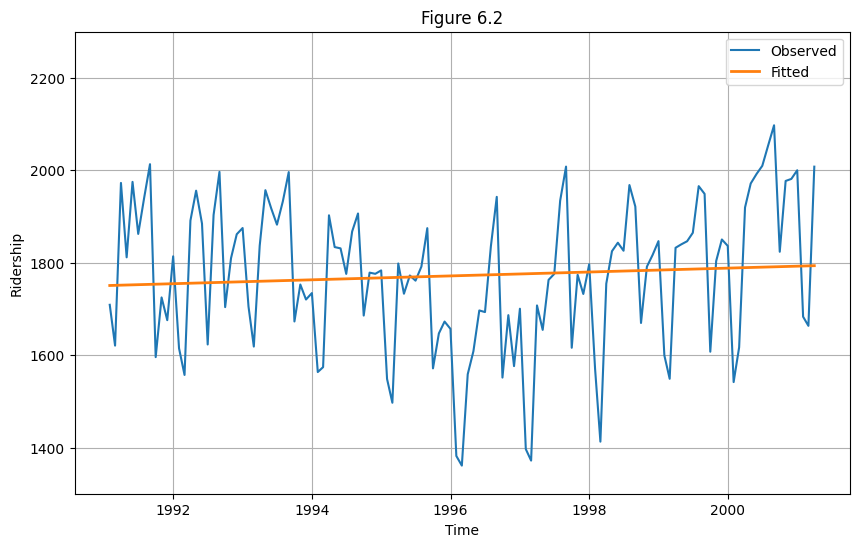

In [12]:
## Figure 6.2 (DataFrame) - Linear trend fitted to Amtrak ridership data
ridership_df = pd.DataFrame(Amtrak_data["Ridership"].values, index=pd.date_range('1991-01', periods=len(Amtrak_data), freq='M'), columns=['ridership'])

n_valid = 36
n_train = len(ridership_df) - n_valid
train_df = ridership_df.iloc[:n_train].copy()  # Using copy() to avoid SettingWithCopyWarning
valid_df = ridership_df.iloc[n_train:n_train+n_valid].copy()  # Using copy() to avoid SettingWithCopyWarning

# Adding a time trend variable
train_df['trend'] = np.arange(len(train_df))

# Fitting a linear model
train_lm = ols(formula='ridership ~ trend', data=train_df).fit()

# Plotting the data and the fitted line
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df['ridership'], label='Observed')
plt.plot(train_df.index, train_lm.fittedvalues, label='Fitted', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Ridership')
plt.ylim([1300, 2300])
plt.title('Figure 6.2')
plt.legend()
plt.grid(True)
plt.show()


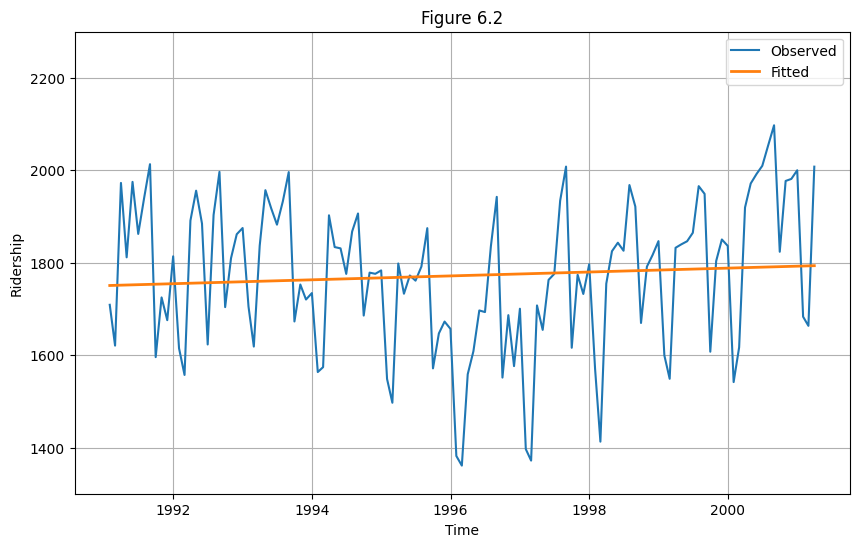

In [4]:
## Figure 6.2 (TimeSeries) - Linear trend fitted to Amtrak ridership data
n_valid = 36
n_train = len(ridership_ts) - n_valid
train_ts = ridership_ts.iloc[:n_train].copy()  # Using copy() to avoid SettingWithCopyWarning
valid_ts = ridership_ts.iloc[n_train:n_train+n_valid].copy()  # Using copy() to avoid SettingWithCopyWarning

# Adding a time trend variable
trend_ts = pd.Series(np.arange(len(train_ts)), index=train_ts.index)

# Fitting a linear model
# You have to create a DataFrame for the model fitting, but it is temporary
train_df_for_model = pd.DataFrame({
    'ridership': train_ts,
    'trend': trend_ts
})
train_lm = ols(formula='ridership ~ trend', data=train_df_for_model).fit()

# Plotting the data and the fitted line
plt.figure(figsize=(10, 6))
plt.plot(train_ts.index, train_ts, label='Observed')
plt.plot(train_ts.index, train_lm.fittedvalues, label='Fitted', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Ridership')
plt.ylim([1300, 2300])
plt.title('Figure 6.2')
plt.legend()
plt.grid(True)
plt.show()


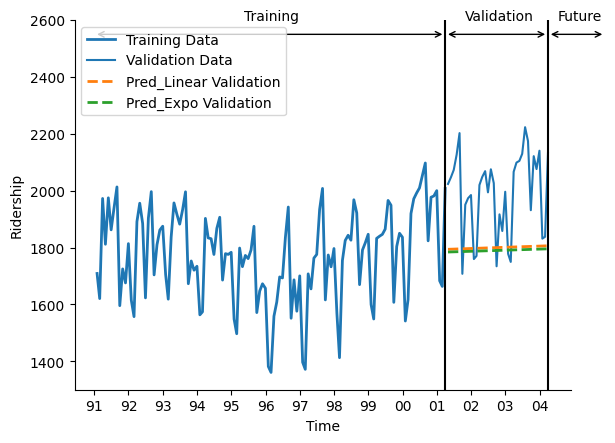

In [17]:
## Figure 6.3|6.4: Exponential (& Linear) trend fitted to amtrak ridership data
nValid = 36
nTrain = len(ridership_ts) - nValid

train = ridership_ts.iloc[:nTrain]
valid = ridership_ts.iloc[nTrain:nTrain + nValid]

# Creating trend variable
train_trend = pd.Series(np.arange(len(train)), index=train.index)
valid_trend = pd.Series(np.arange(nTrain, nTrain + nValid), index=valid.index)

# Add a constant to the trend variables
train_trend = sm.add_constant(train_trend)
valid_trend = sm.add_constant(valid_trend)

# Fitting models
model_linear = OLS(train, train_trend).fit()
model_expo = OLS(np.log(train), train_trend).fit()

# Making predictions
pred_linear = model_linear.predict(valid_trend)
pred_expo = np.exp(model_expo.predict(valid_trend))

# Define & Visualize
pred_dict_train = {}
pred_dict_valid = {'Pred_Linear': pred_linear, 'Pred_Expo':pred_expo }

Amtrak_PlotGraph(train, valid, pred_dict_train, pred_dict_valid, TextHight=2600)


In [13]:
##Table 6.1: SUmmary of output from linear regression model
print(model_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7456
Date:                Thu, 03 Aug 2023   Prob (F-statistic):              0.390
Time:                        15:46:25   Log-Likelihood:                -797.95
No. Observations:                 123   AIC:                             1600.
Df Residuals:                     121   BIC:                             1606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1750.7109     28.720     60.957      0.0

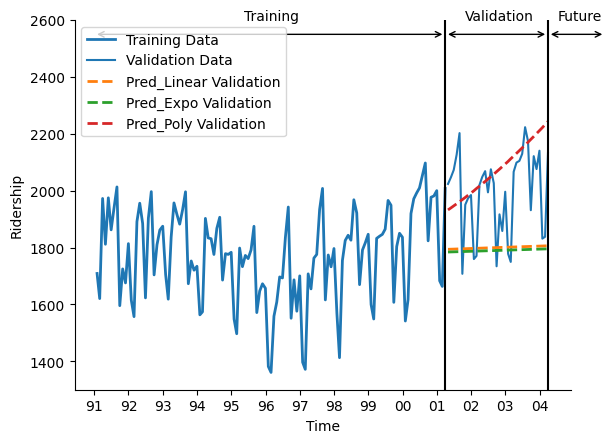

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     10.58
Date:                Thu, 03 Aug 2023   Prob (F-statistic):           5.84e-05
Time:                        15:48:32   Log-Likelihood:                -788.33
No. Observations:                 123   AIC:                             1583.
Df Residuals:                     120   BIC:                             1591.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1882.6398     39.606     47.534      0.0

In [18]:
## TABLE 6.2 (With Graph)

nValid = 36
nTrain = len(ridership_ts) - nValid

train = ridership_ts.iloc[:nTrain]
valid = ridership_ts.iloc[nTrain:nTrain + nValid]

# Creating trend variable
train_trend = pd.Series(np.arange(len(train)), index=train.index)
valid_trend = pd.Series(np.arange(nTrain, nTrain + nValid), index=valid.index)

# Creating polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)  # degree=2 for a quadratic term
train_trend_poly = pd.DataFrame(poly.fit_transform(train_trend.values.reshape(-1, 1)), index=train.index)
valid_trend_poly = pd.DataFrame(poly.fit_transform(valid_trend.values.reshape(-1, 1)), index=valid.index)

# Add a constant to the trend variables
train_trend = sm.add_constant(train_trend)
valid_trend = sm.add_constant(valid_trend)
train_trend_poly = sm.add_constant(train_trend_poly)
valid_trend_poly = sm.add_constant(valid_trend_poly)

# Fitting models
model_linear = OLS(train, train_trend).fit()
model_expo = OLS(np.log(train), train_trend).fit()
model_poly = OLS(train, train_trend_poly).fit()

# Making predictions
pred_linear = model_linear.predict(valid_trend)
pred_expo = np.exp(model_expo.predict(valid_trend))
pred_poly = model_poly.predict(valid_trend_poly)

# Define & Visualize
pred_dict_train = {}
pred_dict_valid = {
    'Pred_Linear': pred_linear
   , 'Pred_Expo':pred_expo
   , 'Pred_Poly': pred_poly
    }

Amtrak_PlotGraph(train, valid, pred_dict_train, pred_dict_valid, TextHight=2600)

# Poly Summary
print(model_poly.summary())


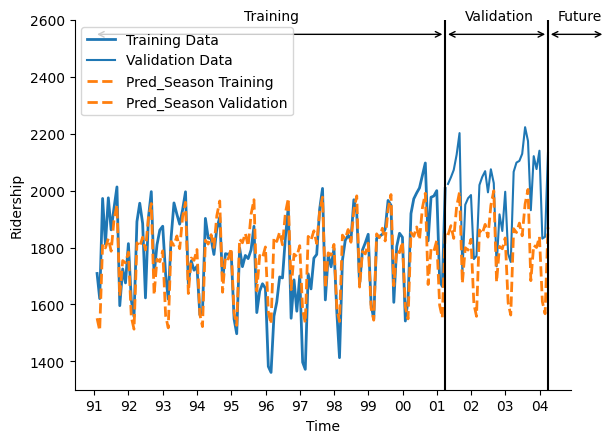

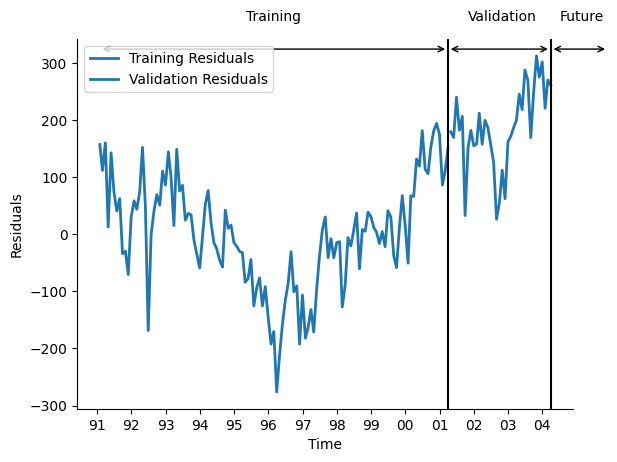

In [19]:
## Figure 6.6: Regression model with seasonality fitted to the Amtrak Ridership data in top panel; Model's Residuals bottom
    ## Results might be slightly different (R tlsm vs. Python OLS)

# Add month column
train_month = pd.DataFrame(train.index.month, index=train.index, columns=['month'])
valid_month = pd.DataFrame(valid.index.month, index=valid.index, columns=['month'])

# Create dummy variables
train_month_dummies = pd.get_dummies(train_month.month, prefix='month')
valid_month_dummies = pd.get_dummies(valid_month.month, prefix='month')

# Combine trend and seasonal features
train_combined = pd.concat([train_trend, train_month_dummies], axis=1)
valid_combined = pd.concat([valid_trend, valid_month_dummies], axis=1)

# Convert boolean to int
train_combined = train_combined.astype(int)
valid_combined = valid_combined.astype(int)

# Add a constant to the trend variables
train_combined = sm.add_constant(train_combined)
valid_combined = sm.add_constant(valid_combined)

# Fitting model
model_season = OLS(train, train_combined).fit()

# Making predictions
pred_season = model_season.predict(valid_combined)

## Define & Visualize TIME SERIES
pred_dict_train = {
    # 'Pred_Linear': model_linear.fittedvalues
    # , 'Pred_Expo': model_expo.fittedvalues
    # , 'Pred_Poly': model_poly.fittedvalues
      'Pred_Season': model_season.fittedvalues ## model_season.predict(train_combined)
    }
pred_dict_valid = {
    # 'Pred_Linear': pred_linear
#    , 'Pred_Expo':pred_expo
#    , 'Pred_Poly': pred_poly
     'Pred_Season': pred_season 
    }

Amtrak_PlotGraph(train, valid, pred_dict_train, pred_dict_valid, TextHight=2600)

## PLOTTING & VISUALIZING RESIDUALS
# Plotting Residuals
train_residuals = train - model_season.fittedvalues
valid_residuals = valid - pred_season

# Visualizing Residuals
Amtrak_PlotResidualsGraph(train_residuals, valid_residuals, TextHight=375)


In [9]:
## Table 6.3: Summary of output from fitting additive seasonality to Amtrak Ridership data
print (model_season.summary()) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     16.42
Date:                Thu, 03 Aug 2023   Prob (F-statistic):           1.88e-19
Time:                        15:44:26   Log-Likelihood:                -735.19
No. Observations:                 123   AIC:                             1496.
Df Residuals:                     110   BIC:                             1533.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1617.5289     16.722     96.732      0.0

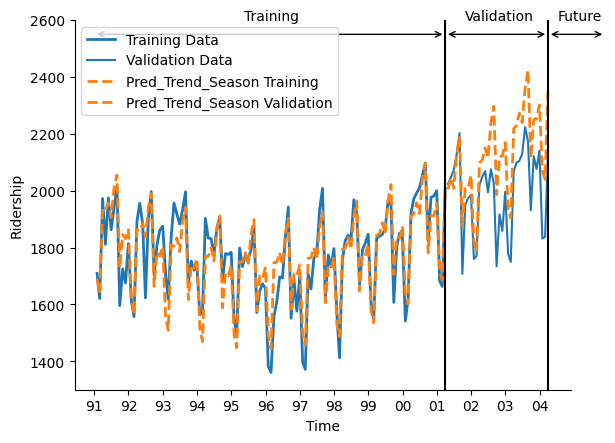

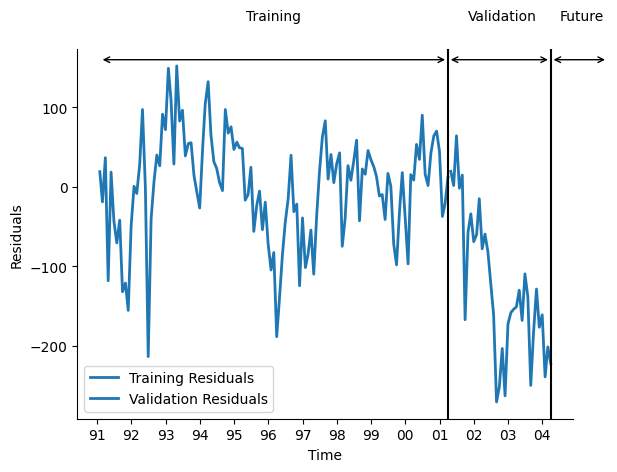

In [20]:
## Figure 6.7: Regression Model with quadratic trend and seasonlity fitted to Amtrak ridership data in top panel. Model residuals - bottom panel

# Define the size of your validation set
nValid = 36
nTrain = len(ridership_ts) - nValid

# Split your data into training and validation sets
train = ridership_ts.iloc[:nTrain]
valid = ridership_ts.iloc[nTrain:nTrain + nValid]

# Define your trend variables
train_trend = pd.Series(np.arange(len(train)), index=train.index)
valid_trend = pd.Series(np.arange(nTrain, nTrain + nValid), index=valid.index)

# Create your polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
train_trend_poly = pd.DataFrame(poly.fit_transform(train_trend.values.reshape(-1, 1)), index=train.index)
valid_trend_poly = pd.DataFrame(poly.transform(valid_trend.values.reshape(-1, 1)), index=valid.index) 

# Add month columns to your datasets
train_month = pd.DataFrame(train.index.month, index=train.index, columns=['month'])
valid_month = pd.DataFrame(valid.index.month, index=valid.index, columns=['month'])

# Create dummy variables for your month columns
train_month_dummies = pd.get_dummies(train_month.month, prefix='month')
valid_month_dummies = pd.get_dummies(valid_month.month, prefix='month')

# Combine your polynomial trend features and your seasonality features
train_combined = pd.concat([train_trend_poly, train_month_dummies], axis=1)
valid_combined = pd.concat([valid_trend_poly, valid_month_dummies], axis=1)

# Convert boolean to int
train_combined = train_combined.astype(int)
valid_combined = valid_combined.astype(int)

# Fit your model to the combined features
train_combined = add_constant(train_combined)
valid_combined = add_constant(valid_combined)
model_trend_season = OLS(train, train_combined).fit()

# Make predictions with your model
pred_trend_season = model_trend_season.predict(valid_combined)

# Store your predictions
pred_dict_train = {'Pred_Trend_Season': model_trend_season.fittedvalues}
pred_dict_valid = {'Pred_Trend_Season': pred_trend_season}

# Visualize your predictions
Amtrak_PlotGraph(train, valid, pred_dict_train, pred_dict_valid, TextHight=2600)

# Calculate and plot residuals
train_residuals = train - model_trend_season.fittedvalues
valid_residuals = valid - pred_trend_season

# Visualizing Residuals
Amtrak_PlotResidualsGraph(train_residuals, valid_residuals, TextHight=210)


In [11]:
## Table 6.4: Summary of output from fitting model with Quadratic trend & seasonlity to Amtrak ridership data
print (model_trend_season.summary()) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     39.42
Date:                Thu, 03 Aug 2023   Prob (F-statistic):           3.75e-35
Time:                        15:44:56   Log-Likelihood:                -691.27
No. Observations:                 123   AIC:                             1411.
Df Residuals:                     109   BIC:                             1450.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1755.7355     17.500    100.328      0.0

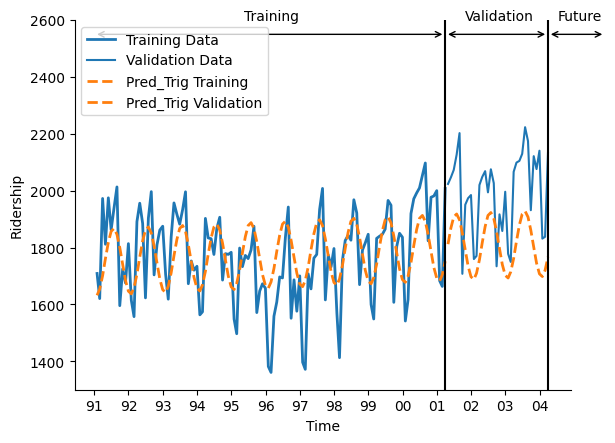

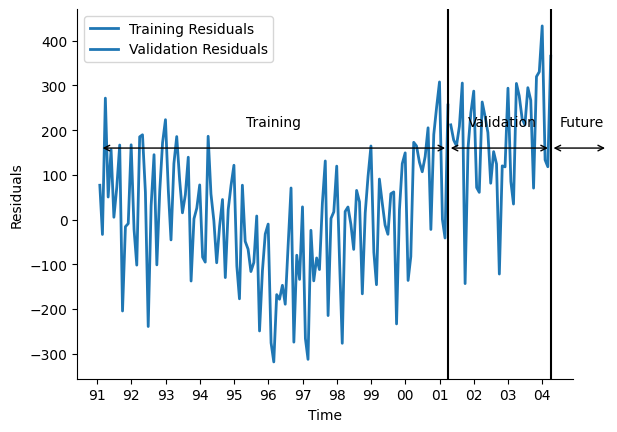

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     15.14
Date:                Thu, 03 Aug 2023   Prob (F-statistic):           2.09e-08
Time:                        15:48:56   Log-Likelihood:                -778.45
No. Observations:                 123   AIC:                             1565.
Df Residuals:                     119   BIC:                             1576.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1748.4564     24.744     70.662      0.0

In [21]:
## Table 6.5 (with Graph)
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Define the size of your validation set
nValid = 36
nTrain = len(ridership_ts) - nValid

# Split your data into training and validation sets
train = ridership_ts.iloc[:nTrain]
valid = ridership_ts.iloc[nTrain:nTrain + nValid]

# Define your trend variables
train_trend = pd.Series(np.arange(len(train)), index=train.index)
valid_trend = pd.Series(np.arange(nTrain, nTrain + nValid), index=valid.index)

# Calculate sine and cosine terms
train_sin = pd.Series(np.sin(2*np.pi*train_trend/12), index=train.index)
train_cos = pd.Series(np.cos(2*np.pi*train_trend/12), index=train.index)
valid_sin = pd.Series(np.sin(2*np.pi*valid_trend/12), index=valid.index)
valid_cos = pd.Series(np.cos(2*np.pi*valid_trend/12), index=valid.index)

# Combine trend and trigonometric features
train_combined = pd.concat([train_trend, train_sin, train_cos], axis=1)
valid_combined = pd.concat([valid_trend, valid_sin, valid_cos], axis=1)

# Add a constant to the trend variables
train_combined = add_constant(train_combined)
valid_combined = add_constant(valid_combined)

# Fit the OLS model
model_trig = OLS(train, train_combined).fit()

# Make predictions with your model
pred_trig = model_trig.predict(valid_combined)

# Store your predictions
pred_dict_train = {'Pred_Trig': model_trig.fittedvalues}
pred_dict_valid = {'Pred_Trig': pred_trig}

# Visualize your predictions
Amtrak_PlotGraph(train, valid, pred_dict_train, pred_dict_valid, TextHight=2600)

# Calculate and plot residuals
train_residuals = train - model_trig.fittedvalues
valid_residuals = valid - pred_trig

# Visualizing Residuals
Amtrak_PlotResidualsGraph(train_residuals, valid_residuals, TextHight=210)

# Trig model Summary
print(model_trig.summary())


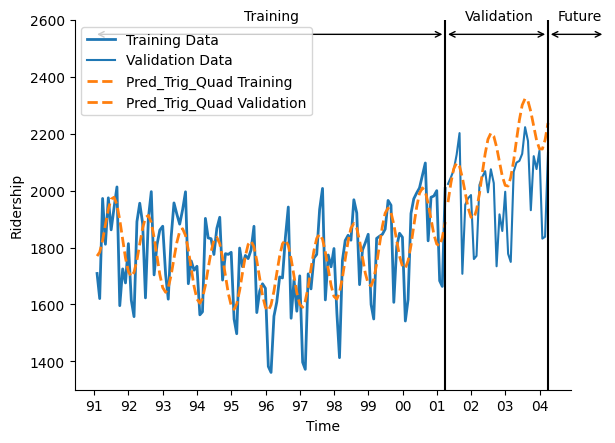

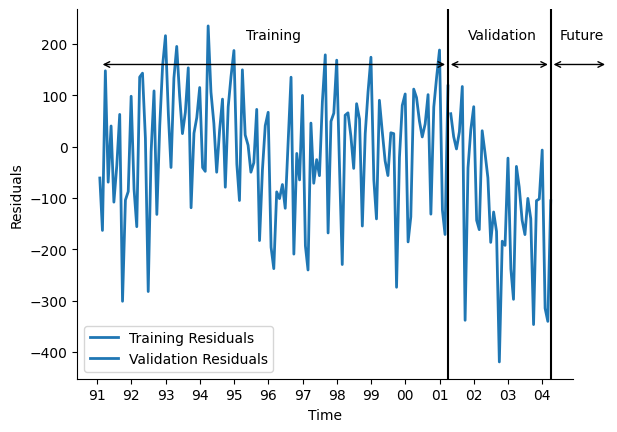

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     23.80
Date:                Thu, 03 Aug 2023   Prob (F-statistic):           1.91e-14
Time:                        15:49:05   Log-Likelihood:                -761.95
No. Observations:                 123   AIC:                             1534.
Df Residuals:                     118   BIC:                             1548.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1892.5839     32.317     58.564      0.0

In [22]:
## FOR FUN >> Adding Quadratic Trend to sinusoidal seasonality >> Not as good as expected
# Define your trend variables
train_trend = pd.Series(np.arange(len(train)), index=train.index)
valid_trend = pd.Series(np.arange(nTrain, nTrain + nValid), index=valid.index)

# Create quadratic trend variables
train_trend_squared = pd.Series(np.square(train_trend), index=train.index)
valid_trend_squared = pd.Series(np.square(valid_trend), index=valid.index)

# Calculate sine and cosine terms
train_sin = pd.Series(np.sin(2*np.pi*train_trend/12), index=train.index)
train_cos = pd.Series(np.cos(2*np.pi*train_trend/12), index=train.index)
valid_sin = pd.Series(np.sin(2*np.pi*valid_trend/12), index=valid.index)
valid_cos = pd.Series(np.cos(2*np.pi*valid_trend/12), index=valid.index)

# Combine trend, quadratic trend and trigonometric features
train_combined = pd.concat([train_trend, train_trend_squared, train_sin, train_cos], axis=1)
valid_combined = pd.concat([valid_trend, valid_trend_squared, valid_sin, valid_cos], axis=1)

# Add a constant to the trend variables
train_combined = add_constant(train_combined)
valid_combined = add_constant(valid_combined)

# Fit the OLS model
model_trig_quad = OLS(train, train_combined).fit()

# Make predictions with your model
pred_trig_quad = model_trig_quad.predict(valid_combined)

# Store your predictions
pred_dict_train = {'Pred_Trig_Quad': model_trig_quad.fittedvalues}
pred_dict_valid = {'Pred_Trig_Quad': pred_trig_quad}

# Visualize your predictions
Amtrak_PlotGraph(train, valid, pred_dict_train, pred_dict_valid, TextHight=2600)

# Calculate and plot residuals
train_residuals = train - model_trig_quad.fittedvalues
valid_residuals = valid - pred_trig_quad

# Visualizing Residuals
Amtrak_PlotResidualsGraph(train_residuals, valid_residuals, TextHight=210)

# Trig model Summary
print(model_trig_quad.summary())
